## Hierarchical models for predicting IoT lifetime

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import warnings
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [2]:
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"

In [3]:
def is_sorted(a):
    '''Check if numpy 1d-array is sorted
    '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a)))
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape))
    return np.all(a[:-1] <= a[1:])

def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x),type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0)
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

def get_quantiles(fx, probs=None):
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even')
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)')
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2))))
    return np.percentile(fx, probs, axis=0)


def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x).
    x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca()
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx)
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")    
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]

    for i in range(int(nq/2)):
        ax.fill_between(x,
                        perc_interv[i,:],
                        perc_interv[-(i+1),:],
                        color=colortab[i],
                        zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder)
    return ax

def integer_histogram_matrix(max_y,y_ppc):
    if len(y_ppc.shape)==1:
        y_ppc=np.expand_dims(y_ppc,axis=0)
    B=max_y+1
    bins = np.array([*range(B+1)])-0.5
    counts = [np.histogram(y_ppc[n], bins=bins)[0] for n in range(y_ppc.shape[0])]
    return bins, np.array(counts)

def real_histogram_matrix(bins,y_ppc):
    if len(y_ppc.shape)==1:
        y_ppc=np.expand_dims(y_ppc,axis=0)
    counts = [np.histogram(y_ppc[n], bins=bins)[0] for n in range(y_ppc.shape[0])]
    return bins, np.array(counts)

def pad_hist_for_plot(bins,counts):
    if len(counts.shape)==1:
        ax=0
    else: ax=1
        
    xs = (np.repeat(bins,repeats=2))[1:-1]
    pad_counts = np.repeat(counts,repeats=2,axis=ax)
    return xs, pad_counts


In [4]:
data_gen2 = CmdStanModel(stan_file='generate_multilevel_data2.stan')
data2 = data_gen2.sample(data={'N_batch':4,'N':200},fixed_param=True,iter_warmup=0,iter_sampling=1,chains=1,seed=30082021)
my_dict = data2.stan_variables()
[my_dict.pop(x, None) for x in ['batch_coef']]
print('batch_coef: {}'.format(data2.stan_variable('batch_coef')))
data_dict = {key:my_dict[key][0] for key in my_dict.keys()}
df = pd.DataFrame(data_dict)
df=df.astype({'resets':'int32','batch':'int32'})


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/generate_multilevel_data2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


batch_coef: [[-0.373246  0.123104  2.01696  -0.771476]]


In [5]:
#batch_coef: [[-0.373246  0.123104  2.01696  -0.771476]]
#df.to_csv('training_data.csv')

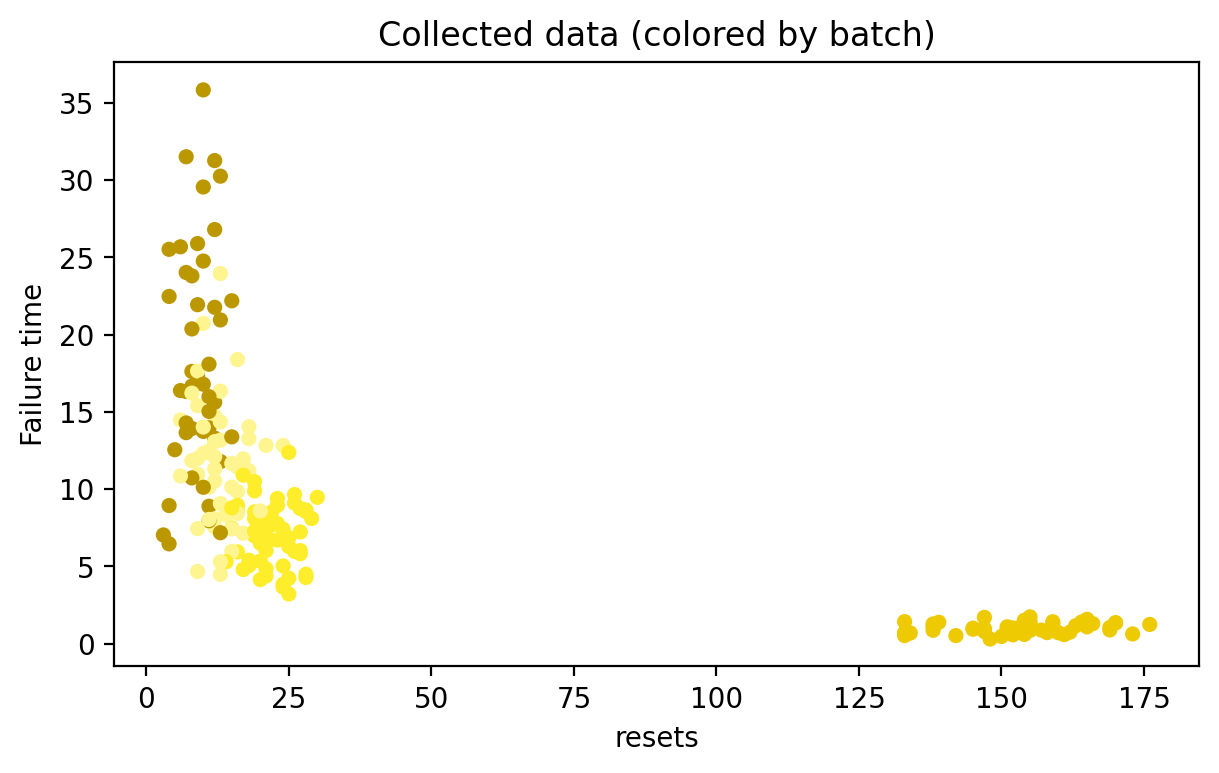

In [6]:
di={1:LIGHT_HIGHLIGHT,2:MID,3:DARK,4:DARK_HIGHLIGHT}
df['batch_c'] = df.batch.map(di)
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax = df.plot.scatter(x='resets',y='failure_time',c='batch_c',ax=ax)
ax.set_title('Collected data (colored by batch)')
ax.set_ylabel('Failure time')
plt.show()
fig.savefig('dataset_colored.png')

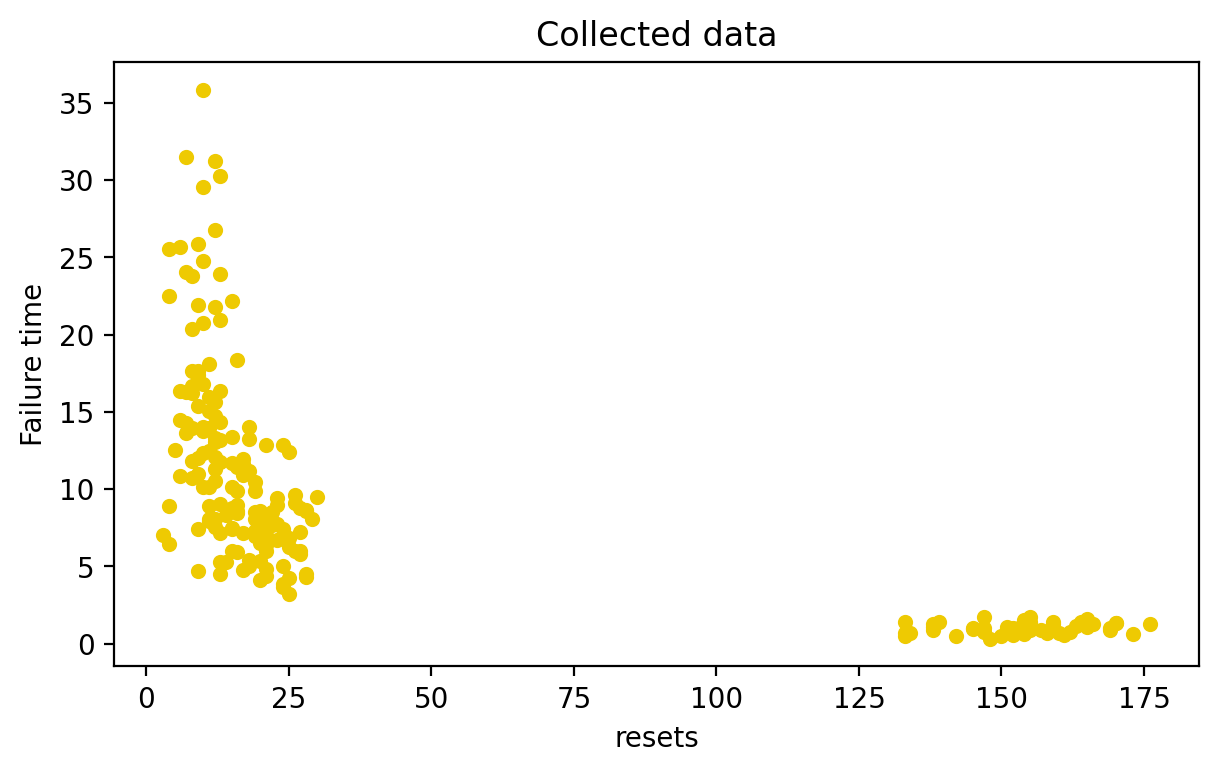

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax = df.plot.scatter(x='resets',y='failure_time',c=DARK,ax=ax)
ax.set_title('Collected data')
ax.set_ylabel('Failure time')
plt.show()
fig.savefig('dataset.png')

In [8]:
multilevel_infer2 = CmdStanModel(stan_file='multilevel_inference2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/multilevel_inference2


In [9]:
data_for_inf = {'N':200,
                'N_batch':4,
                'batch':df.batch.values,
                'resets':df.resets.values,
                'failure_time':df.failure_time.values}
multileve_result2 = multilevel_infer2.sample(data_for_inf,seed=29082021, adapt_delta=.99, max_treedepth=50)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [10]:
posterior_summary = az.summary(multileve_result2,var_names=['~pred_failure_time','~pred_resets'],filter_vars='like')
#-0.373246  0.123104  2.01696  -0.771476

index_of_variables = ['$\lambda_{reset}$', '$\kappa$',
                      '$\mu_{batch}$', '$\sigma_{batch}$' ,
                      '$\\tilde{\\alpha}_{batch,1}$',
                      '$\\tilde{\\alpha}_{batch,2}$',
                      '$\\tilde{\\alpha}_{batch,3}$',
                      '$\\tilde{\\alpha}_{batch,4}$',
                      '$\\beta_1$',
                      '$\\beta_2$',
                      '$\\beta_3$',
                      '$\\beta_4$'
                      ]
posterior_summary.index=index_of_variables

tex_file = open("table_posterior_summary.tex", "w")
n = tex_file.write(posterior_summary.to_latex(escape=False))
tex_file.close()

posterior_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\lambda_{reset}$,2.960,0.080,2.811,3.111,0.002,0.002,1337.0,1671.0,1.00
$\kappa$,8.164,0.615,7.072,9.395,0.017,0.012,1262.0,1378.0,1.00
$\mu_{batch}$,0.145,0.621,-1.122,1.244,0.020,0.015,988.0,1170.0,1.00
$\sigma_{batch}$,1.497,0.609,0.637,2.585,0.019,0.013,990.0,1248.0,1.00
"$\tilde{\alpha}_{batch,1}$",-0.411,0.453,-1.236,0.443,0.016,0.012,813.0,1083.0,1.00
"$\tilde{\alpha}_{batch,2}$",-0.019,0.420,-0.792,0.779,0.014,0.010,893.0,1035.0,1.01
"$\tilde{\alpha}_{batch,3}$",1.462,0.646,0.320,2.736,0.020,0.014,1079.0,1121.0,1.00
"$\tilde{\alpha}_{batch,4}$",-0.712,0.504,-1.608,0.244,0.018,0.013,773.0,980.0,1.00
$\beta_1$,-0.376,0.084,-0.543,-0.231,0.002,0.002,1412.0,1596.0,1.00
$\beta_2$,0.137,0.082,-0.005,0.300,0.002,0.002,1398.0,1781.0,1.00


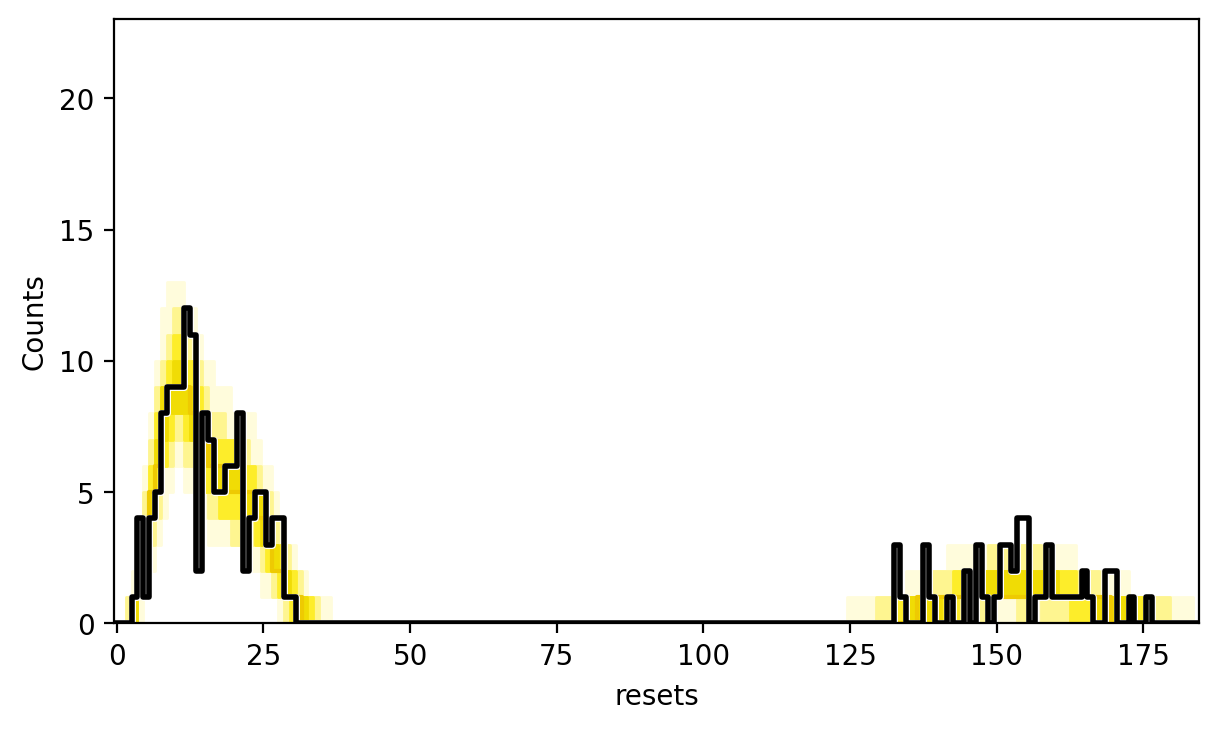

In [11]:
max_y = 184

y_prediction_1 = multileve_result2.stan_variable('pred_resets')

bins,counts = integer_histogram_matrix(max_y,y_prediction_1)
xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    
obs_counts = np.histogram(df.resets, bins=bins)[0]
_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)

#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True)

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("resets")
ax.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
ax.set_ylabel("Counts")


plt.show()
fig.savefig('ppd_resets.png')

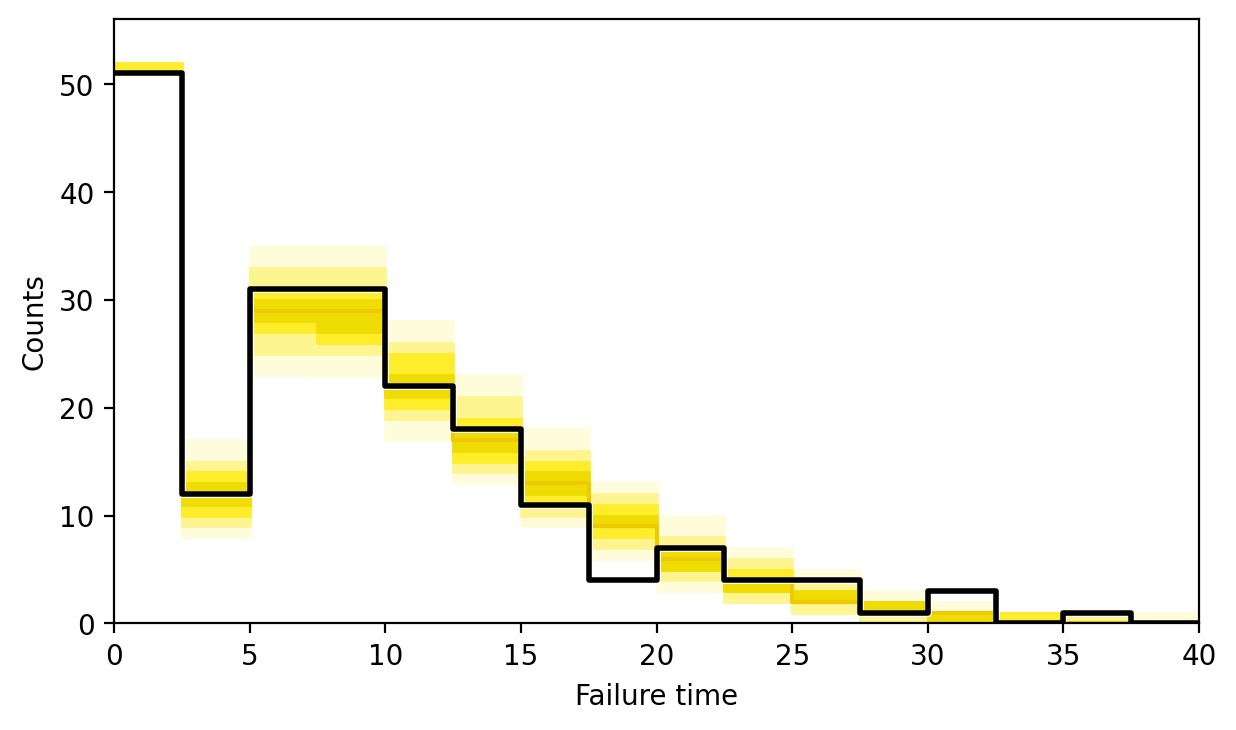

In [34]:
y_prediction_1 = multileve_result2.stan_variable('pred_failure_time')

obs_counts,bins = np.histogram(df.failure_time,bins=np.linspace(0,40,17))
_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)
bins,counts = real_histogram_matrix(bins,y_prediction_1)
xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    


#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True)

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("Failure time")
ax.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
ax.set_ylabel("Counts")


plt.show()
fig.savefig('ppd_failure_time.png')

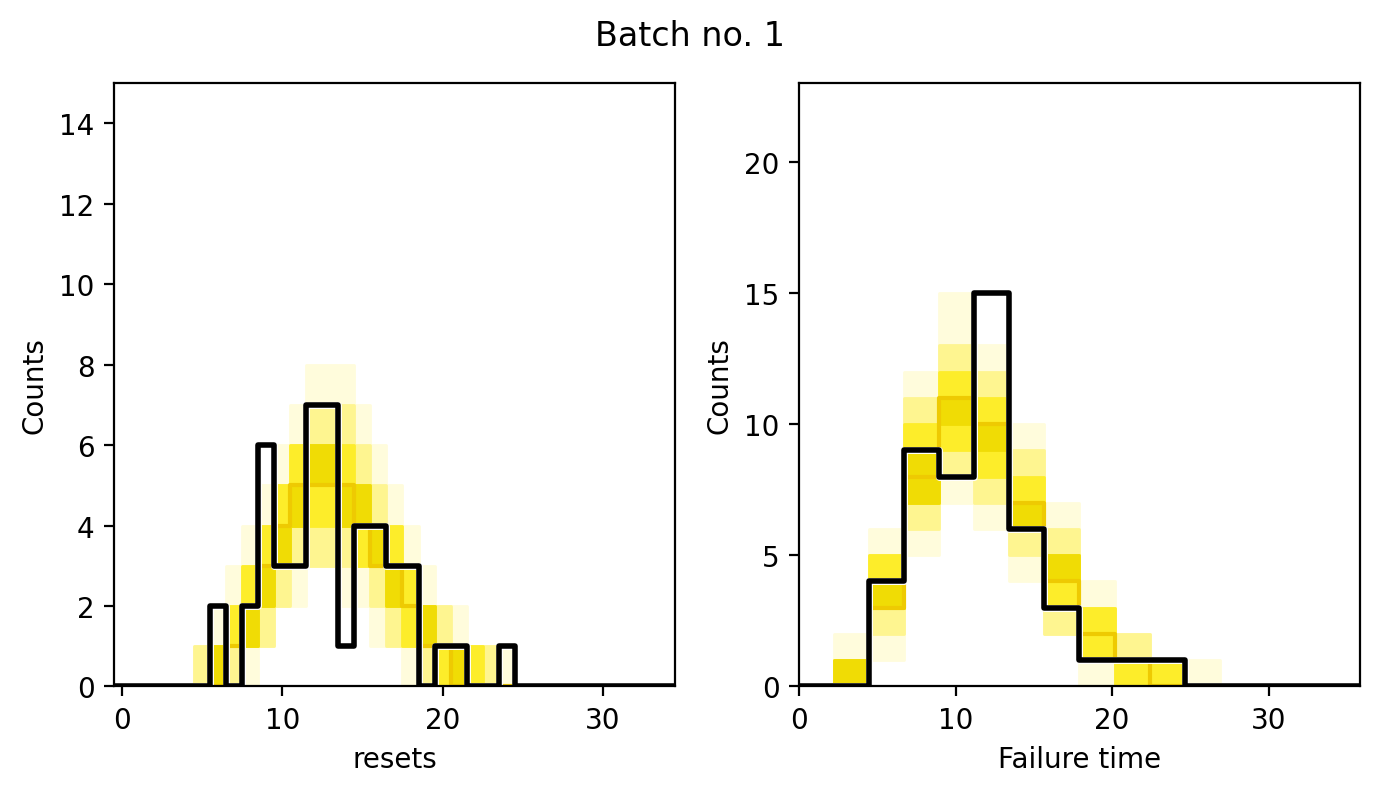

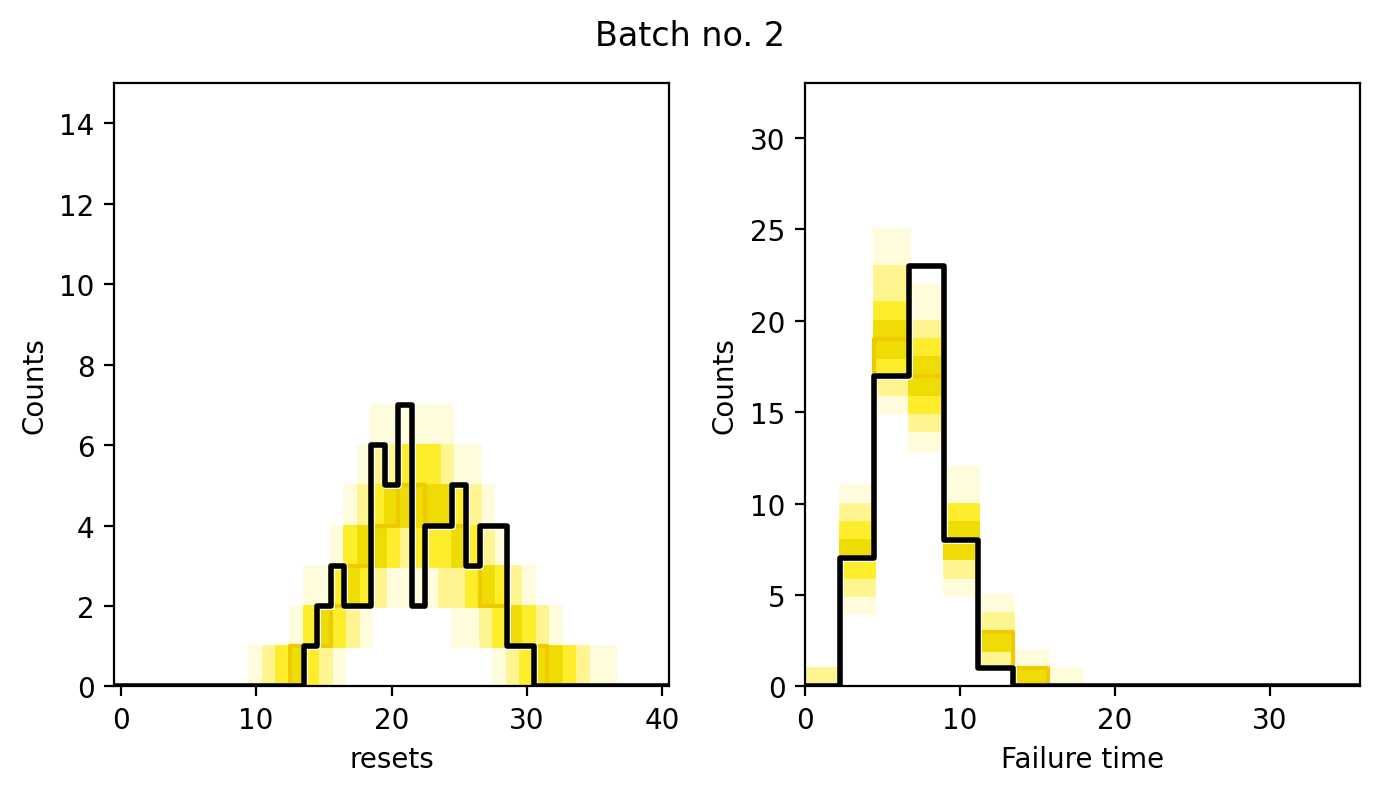

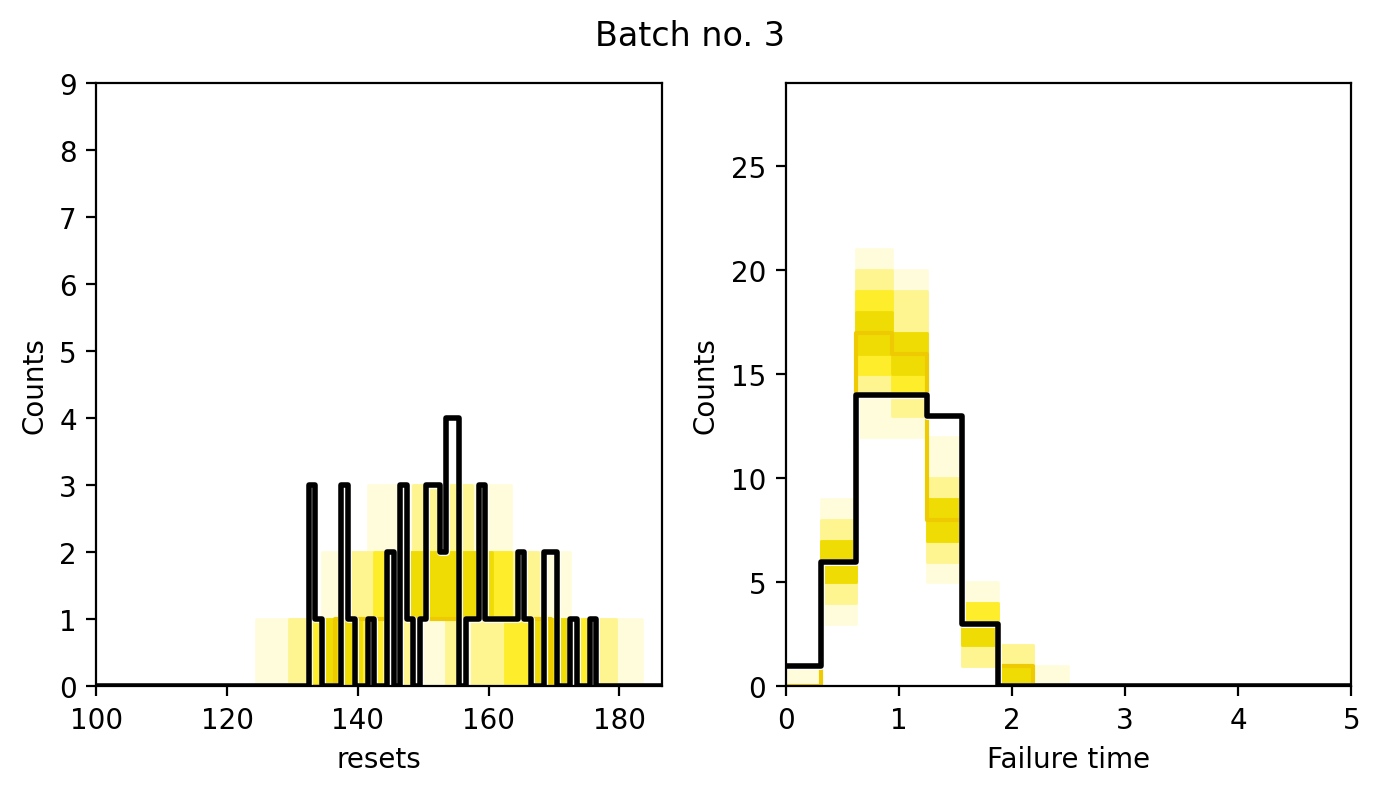

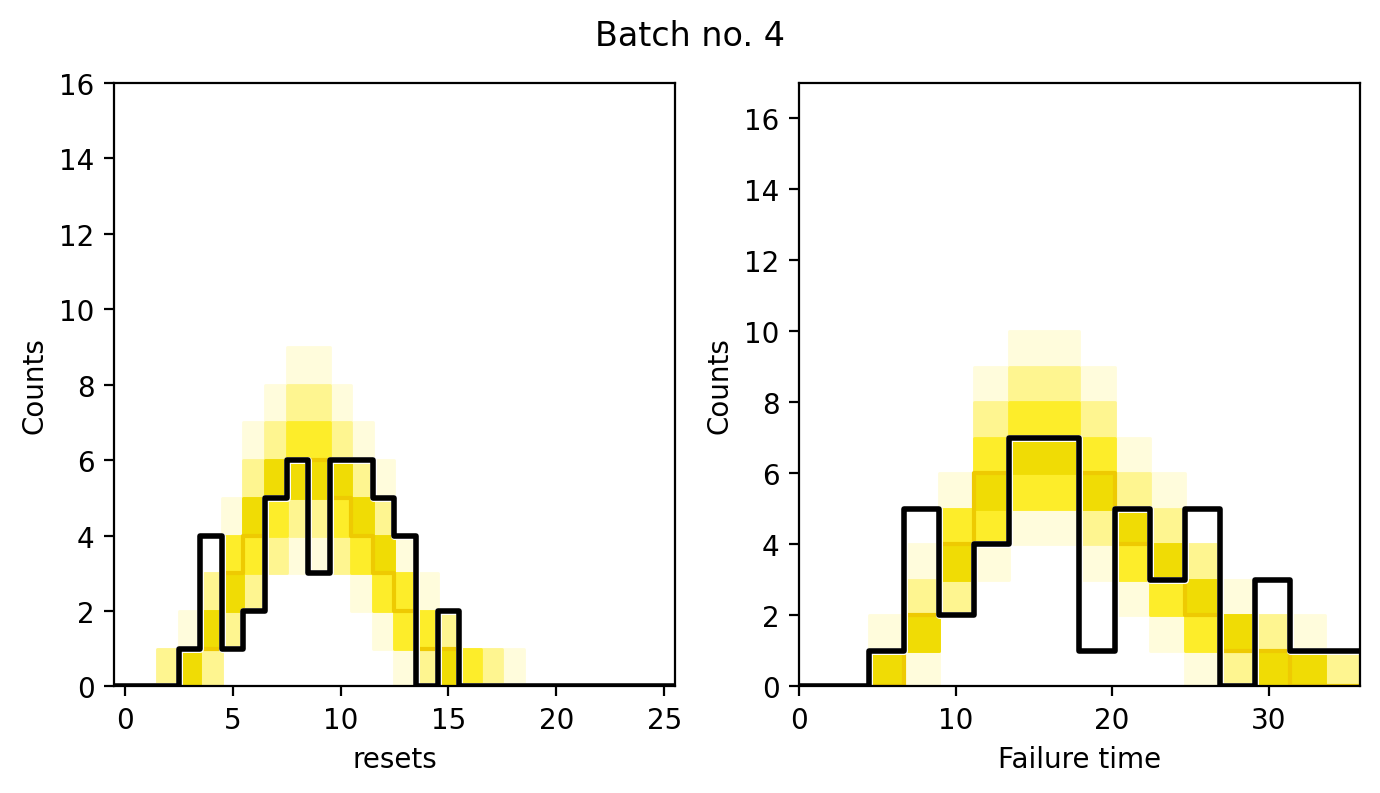

In [38]:
for batch_no in range(1,5):
    y_prediction_1 = multileve_result2.stan_variable('pred_resets')
    batch1 = np.array([resets[df.batch==batch_no] for resets in y_prediction_1])
    max_y = np.max(df.resets[df.batch==batch_no])+10


    bins,counts = integer_histogram_matrix(max_y,batch1)
    xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    
    obs_counts = np.histogram(df.resets[df.batch==batch_no], bins=bins)[0]
    _, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)

    #obs_counts = np.histogram(df['y'], bins=bins)[0]
    #_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


    fig, (ax,ax2) = plt.subplots(1, 2, figsize=(7,4))

    ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True)

    ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
    ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

 

    ax.set_xlim([min(bins), max(bins)])
    if batch_no == 3:
        ax.set_xlim([100, max(bins)])
    ax.set_xlabel("resets")
    ax.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
    ax.set_ylabel("Counts")


    y_prediction_2 = multileve_result2.stan_variable('pred_failure_time')

    batch2 = np.array([failure_time[df.batch==batch_no] for failure_time in y_prediction_2])

    max_time = np.max(df.failure_time)
    if batch_no == 3:
        max_time = 5

    obs_counts,bins = np.histogram(df.failure_time[df.batch==batch_no],bins=np.linspace(0,max_time,17))

    _, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)
    bins,counts = real_histogram_matrix(bins,batch2)
    xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    



    ax2=ribbon_plot(xs,pad_counts_pred,ax2,supress_warning=True)

    ax2.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
    ax2.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

    ax2.set_xlim([min(bins), max(bins)])
    ax2.set_xlabel("Failure time")
    ax2.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
    ax2.set_ylabel("Counts")

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Batch no. {}'.format(batch_no))
    fig.savefig('individual_ppd_batch_{}.png'.format(batch_no))


In [14]:
multilevel_ppc = CmdStanModel(stan_file='multilevel_ppc_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/multilevel_ppc_2


In [15]:
result_ppc = multilevel_ppc.sample(data={'N_batch':4,'N':200,'batch':df.batch.values},
                                        fixed_param=True,
                                        iter_warmup=0,
                                        iter_sampling=1000,
                                        chains=1,seed=30082021)


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [16]:
ppc_summary = az.summary(result_ppc,var_names=['~pred_failure_time','~pred_resets'],filter_vars='like').drop('r_hat',axis=1)
ppc_summary

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail
reset_intercept,3.024,1.009,1.112,4.902,0.031,0.023,1036.0,1026.0
shape,7.965,0.987,6.125,9.749,0.031,0.022,1022.0,981.0
mu_batch,-0.060,1.039,-2.160,1.717,0.032,0.026,1050.0,927.0
sigma_batch,1.597,1.203,0.001,3.895,0.041,0.029,856.0,880.0
alpha_batch_tilde[0],-0.005,1.025,-1.800,1.982,0.034,0.025,925.0,775.0
alpha_batch_tilde[1],0.036,0.979,-1.871,1.736,0.031,0.025,1022.0,773.0
alpha_batch_tilde[2],0.005,0.976,-1.841,1.742,0.031,0.023,991.0,909.0
alpha_batch_tilde[3],0.035,0.977,-1.654,2.027,0.031,0.023,1025.0,844.0
batch_coef[0],-0.107,2.224,-4.079,4.572,0.074,0.053,941.0,824.0
batch_coef[1],0.027,2.155,-4.507,3.939,0.069,0.055,979.0,941.0


In [17]:
ppc_summary.index=index_of_variables

tex_file = open("table_ppc_summary.tex", "w")
n = tex_file.write(ppc_summary.to_latex(escape=False))
tex_file.close()



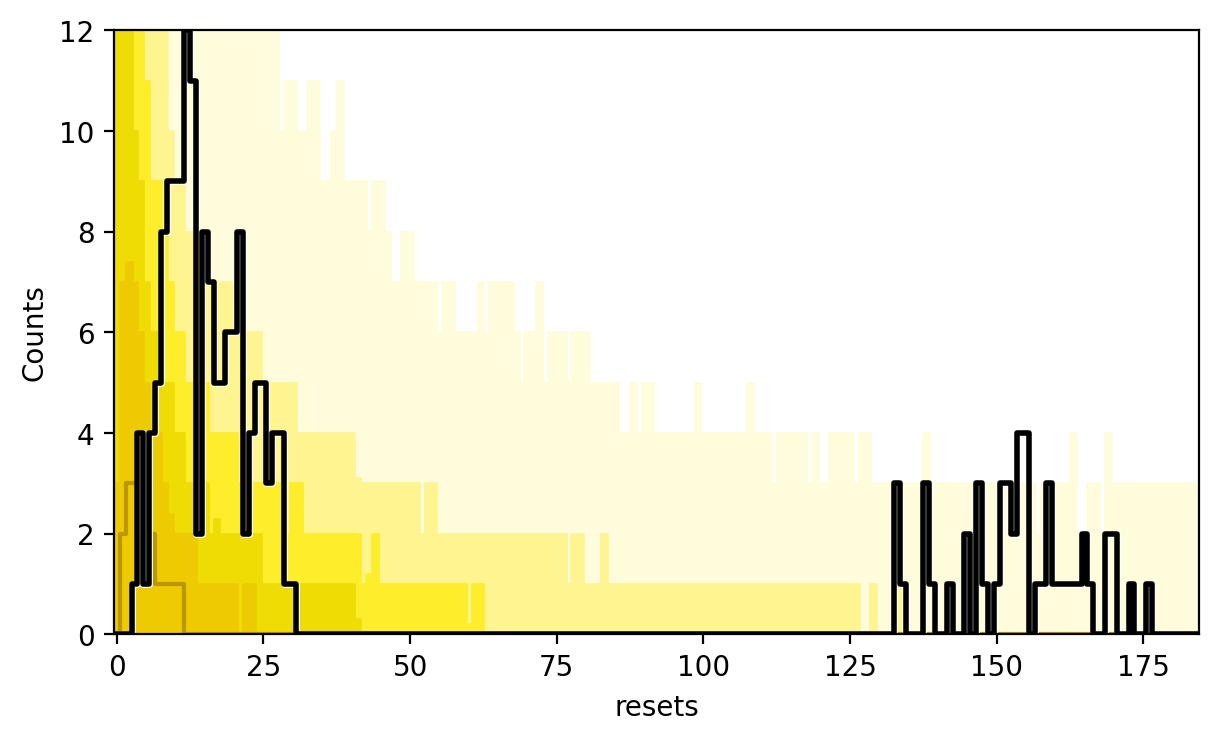

In [18]:
max_y = 184

y_ppc_1 = result_ppc.stan_variable('pred_resets')

bins,counts = integer_histogram_matrix(max_y,y_ppc_1)
xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    
obs_counts = np.histogram(df.resets, bins=bins)[0]
_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)

#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True,probs=[1,10, 20, 30, 40, 50, 60, 70, 80, 90,99])

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("resets")
ax.set_ylim([0, max(obs_counts)])
ax.set_ylabel("Counts")


plt.show()
fig.savefig('ppd_resets.png')

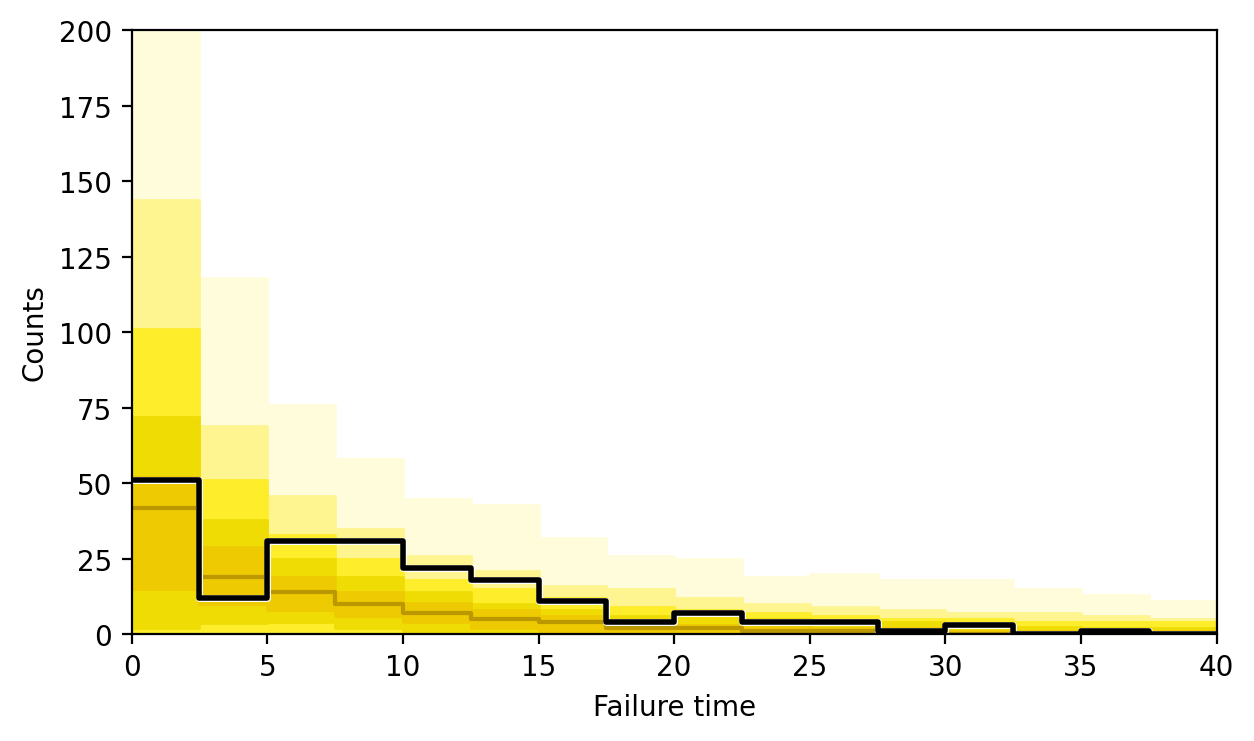

In [19]:
y_ppc_2 = result_ppc.stan_variable('pred_failure_time')

obs_counts,bins = np.histogram(df.failure_time,bins=np.linspace(0,40,17))
_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)
bins,counts = real_histogram_matrix(bins,y_ppc_2)
xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    


#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True,probs=[1,10, 20, 30, 40, 50, 60, 70, 80, 90,99])

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("Failure time")
ax.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
ax.set_ylabel("Counts")


plt.show()
fig.savefig('ppd_failure_time.png')

In [20]:
sbc_model = CmdStanModel(stan_file='multilevel_sbc_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/multilevel_sbc_2


In [21]:
def compute_ranks(i):
    result_sbc = sbc_model.sample(data={'N_batch':4,'N':200,'batch':df.batch.values})
    ranks=(np.sum(result_sbc.stan_variable('lt_sim')[np.arange(0, 4000 - 7, 8)],axis=0))
    return ranks

In [22]:
import multiprocessing
pool = multiprocessing.Pool(4)
ensemble_output = pool.map(compute_ranks,range(10))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO

In [24]:
new_ranks=[]
for i in range(10):
   new_ranks.append(compute_ranks(i)) 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

In [27]:
import scipy.stats as stats
ranks_np = np.genfromtxt('ranks_N1000.csv', delimiter=',')
R=len(ranks_np)
#np.savetxt("ranks_N{}.csv".format(R), ranks_np, delimiter=",")

sbc_low = stats.binom.ppf(0.005, R, 25.0 / 500)
sbc_mid = stats.binom.ppf(0.5, R, 25.0 / 500)
sbc_high = stats.binom.ppf(0.995, R, 25.0 / 500)

bar_x = [-10, 510, 500, 510, -10, 0, -10]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]

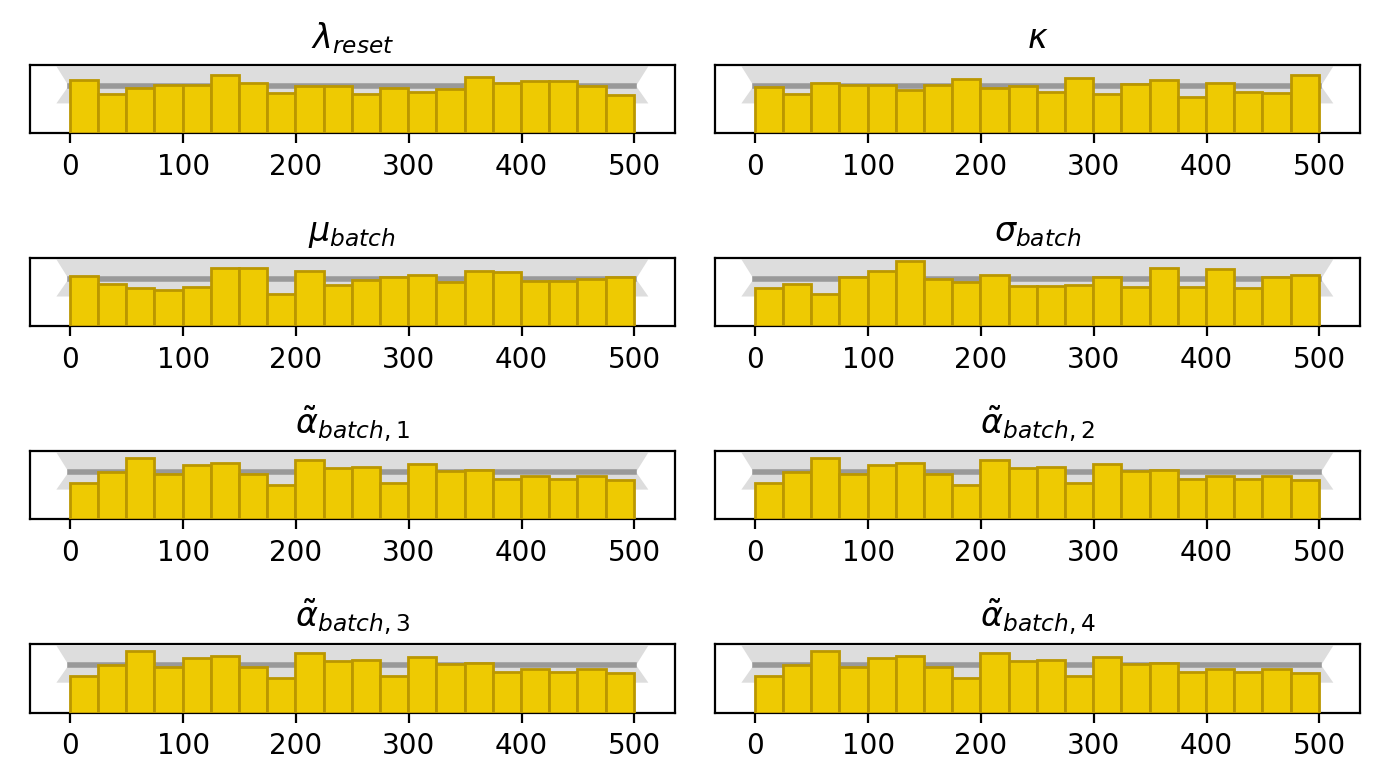

In [28]:
fig, axes = plt.subplots(4,2,figsize=(7,4))
list_of_variables = ['$\lambda_{{reset}}$', '$\kappa$',
                      '$\mu_{{batch}}$', '$\sigma_{{batch}}$' ,
                      '$\\tilde{{\\alpha}}_{{batch,1}}$',
                      '$\\tilde{{\\alpha}}_{{batch,2}}$',
                      '$\\tilde{{\\alpha}}_{{batch,3}}$',
                      '$\\tilde{{\\alpha}}_{{batch,4}}$']
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    name = list_of_variables[i]

    sbc_ranks = ranks_np[:,i]
    if i>4:
        sbc_ranks = ranks_np[:,4]

    ax.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
    ax.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)
    ax.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
          color=DARK, ec=DARK_HIGHLIGHT, zorder=3)
    ax.set_title(name)
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('sbc_results.png')

In [30]:
data_for_inf = {'N':200,
                'resets':df.resets.values,
                'failure_time':df.failure_time.values}
inference = CmdStanModel(stan_file='inference_simple.stan')
infer_result = inference.sample(data_for_inf,seed=29082021)

INFO:cmdstanpy:compiling stan program, exe file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/inference_simple
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/inference_simple
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


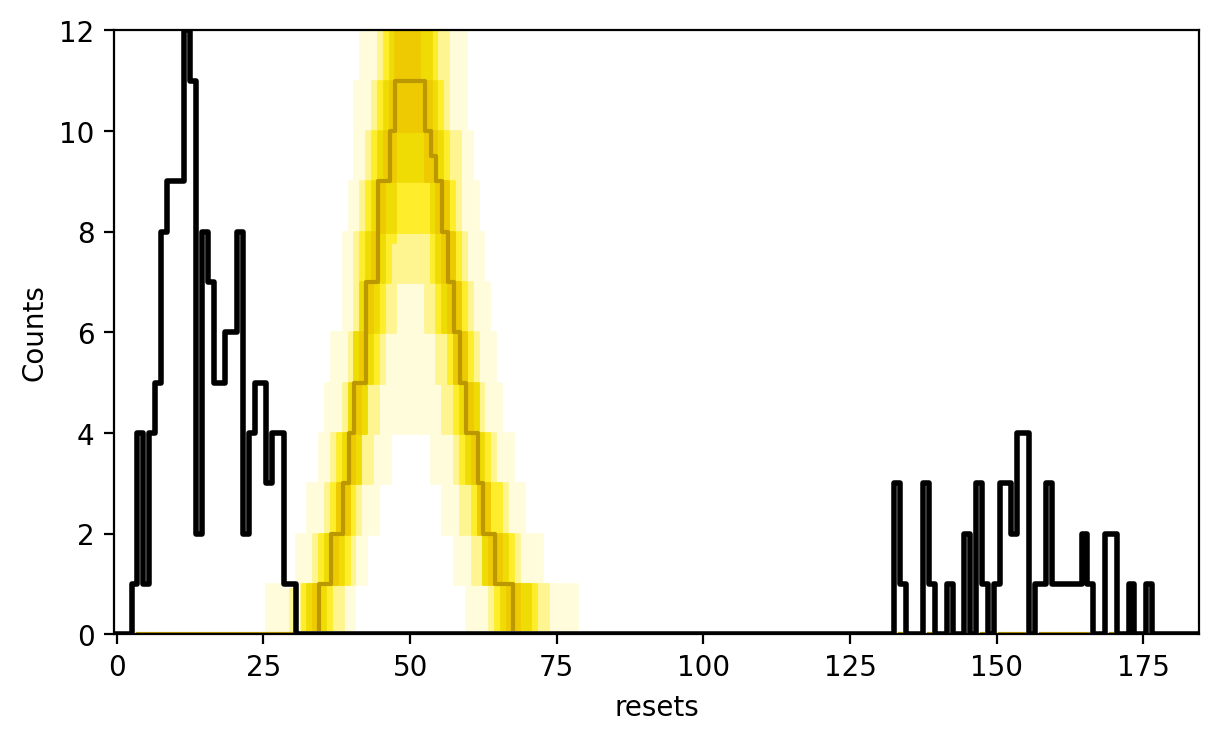

In [31]:
max_y = 184

simple_ppd_1 = infer_result.stan_variable('pred_resets')

bins,counts = integer_histogram_matrix(max_y,simple_ppd_1)
xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    
obs_counts = np.histogram(df.resets, bins=bins)[0]
_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)

#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True,probs=[1,10, 20, 30, 40, 50, 60, 70, 80, 90,99])

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("resets")
ax.set_ylim([0, max(obs_counts)])
ax.set_ylabel("Counts")


plt.show()
fig.savefig('simple_ppd_resets.png')

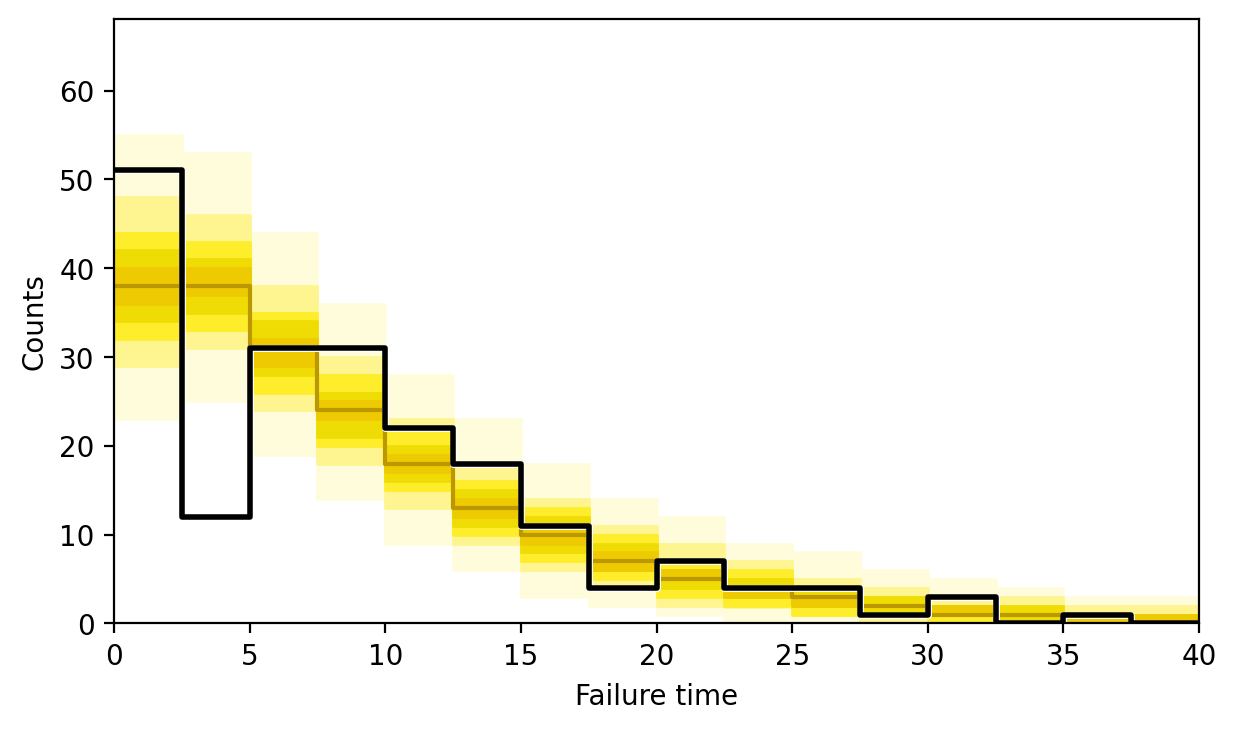

In [33]:
simple_ppd_2 = infer_result.stan_variable('pred_failure_time')

obs_counts,bins = np.histogram(df.failure_time,bins=np.linspace(0,40,17))
_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)
bins,counts = real_histogram_matrix(bins,simple_ppd_2)
xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    


#obs_counts = np.histogram(df['y'], bins=bins)[0]
#_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True,probs=[1,10, 20, 30, 40, 50, 60, 70, 80, 90,99])

ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel("Failure time")
ax.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
ax.set_ylabel("Counts")


plt.show()
fig.savefig('simple_ppd_failure_time.png')

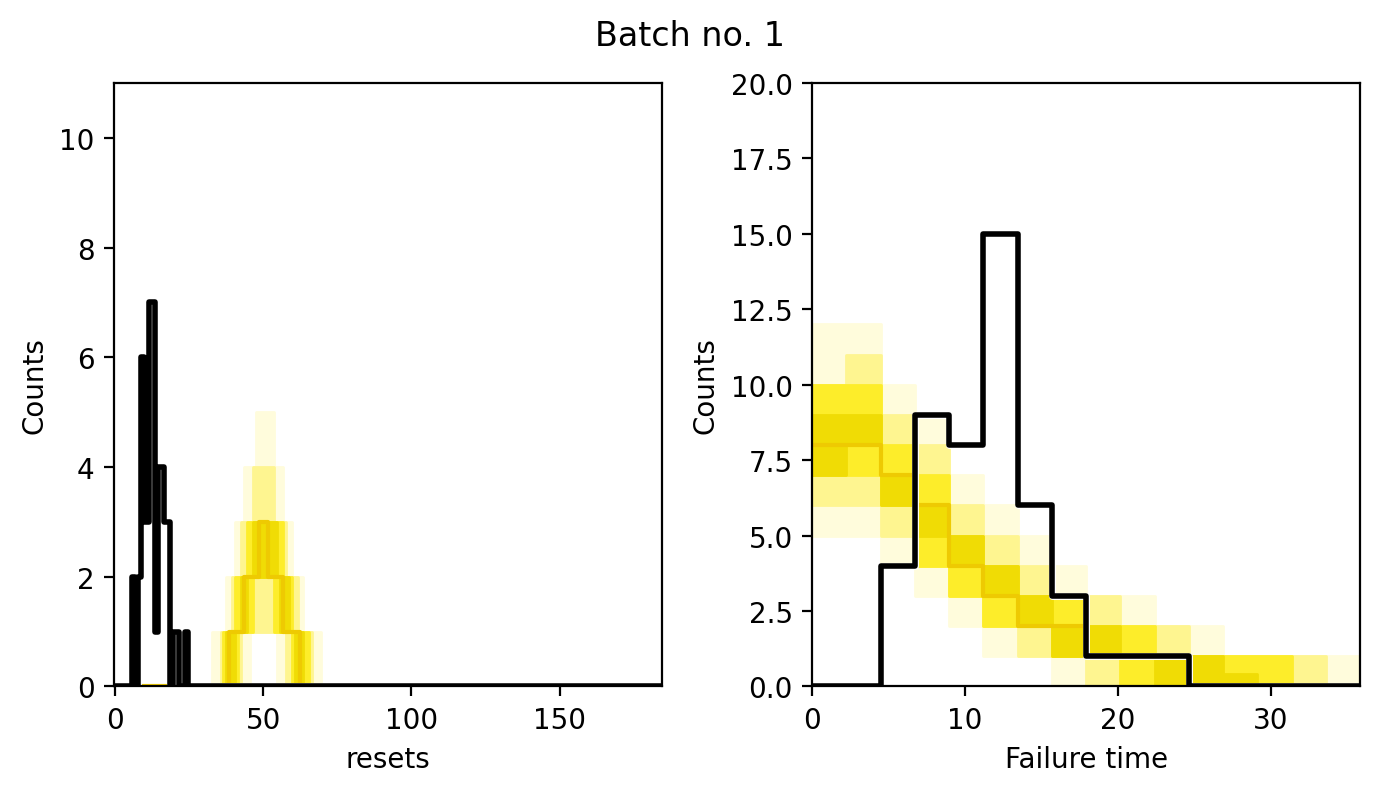

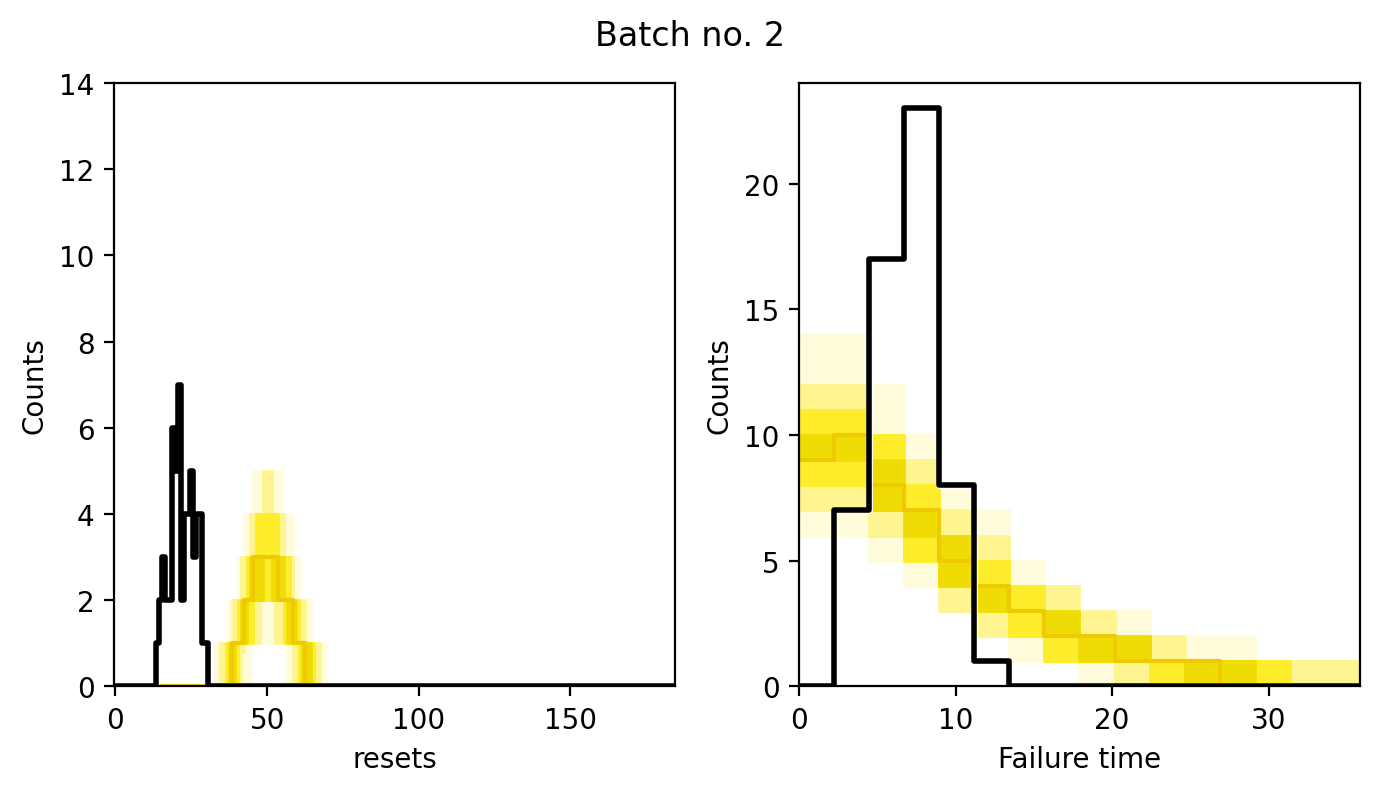

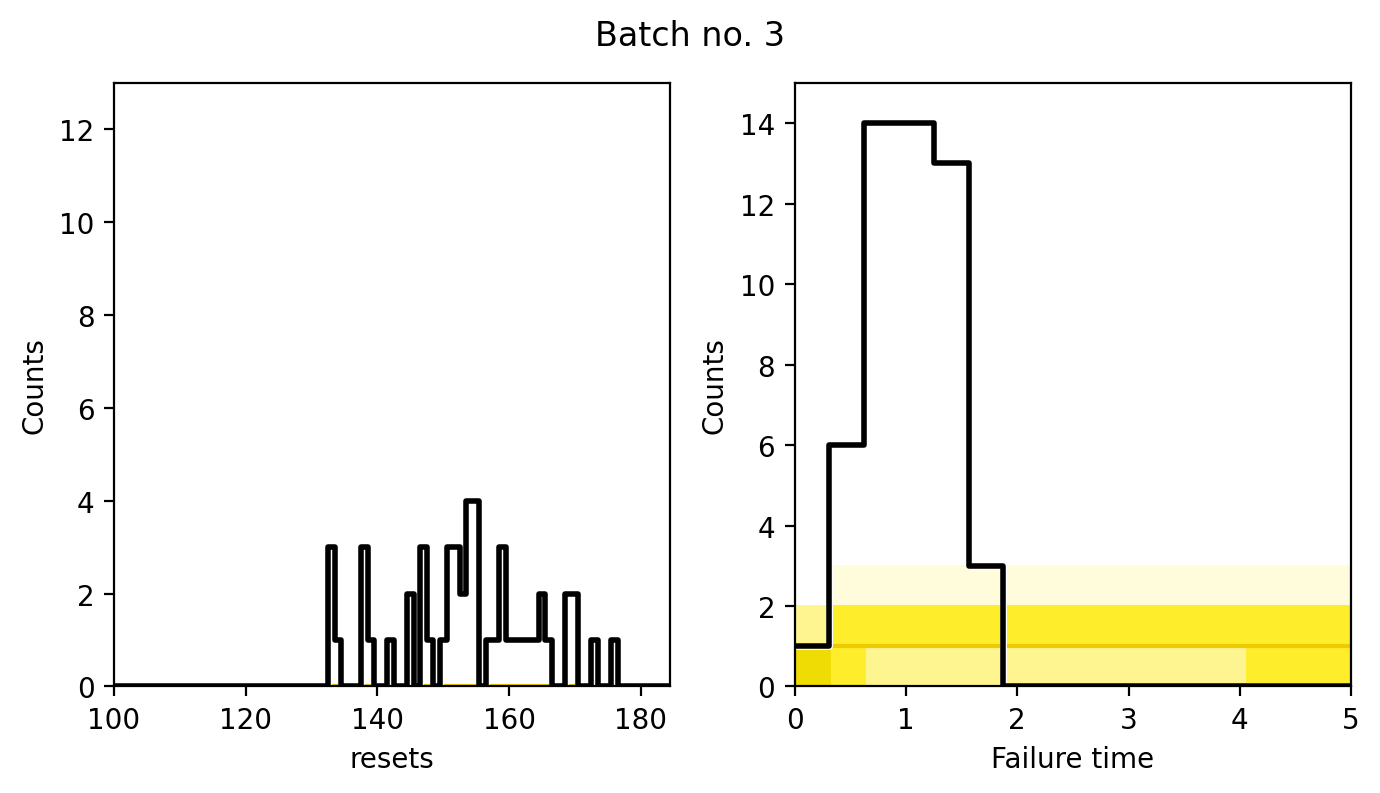

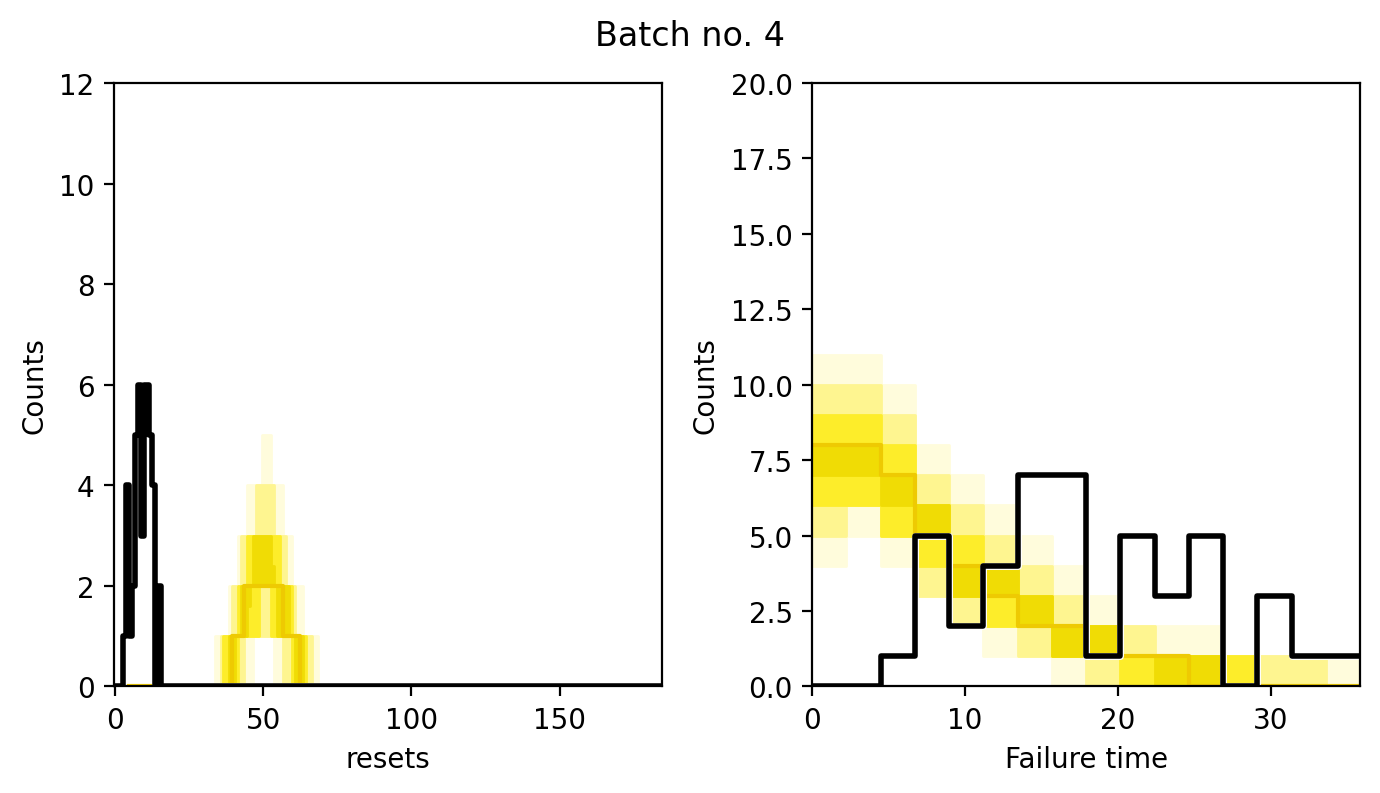

In [41]:
for batch_no in range(1,5):
    y_prediction_1 = infer_result.stan_variable('pred_resets')
    batch1 = np.array([resets[df.batch==batch_no] for resets in y_prediction_1])
    max_y = 184

    bins,counts = integer_histogram_matrix(max_y,batch1)
    xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    
    obs_counts = np.histogram(df.resets[df.batch==batch_no], bins=bins)[0]
    _, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)

    #obs_counts = np.histogram(df['y'], bins=bins)[0]
    #_, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)


    fig, (ax,ax2) = plt.subplots(1, 2, figsize=(7,4))

    ax=ribbon_plot(xs,pad_counts_pred,ax,supress_warning=True)

    ax.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
    ax.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

 

    ax.set_xlim([min(bins), max(bins)])
    if batch_no == 3:
        ax.set_xlim([100, max(bins)])
    ax.set_xlabel("resets")
    ax.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
    ax.set_ylabel("Counts")


    y_prediction_2 = infer_result.stan_variable('pred_failure_time')

    batch2 = np.array([failure_time[df.batch==batch_no] for failure_time in y_prediction_2])

    max_time = np.max(df.failure_time)
    if batch_no == 3:
        max_time = 5

    obs_counts,bins = np.histogram(df.failure_time[df.batch==batch_no],bins=np.linspace(0,max_time,17))

    _, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)
    bins,counts = real_histogram_matrix(bins,batch2)
    xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    



    ax2=ribbon_plot(xs,pad_counts_pred,ax2,supress_warning=True)

    ax2.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
    ax2.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)

    ax2.set_xlim([min(bins), max(bins)])
    ax2.set_xlabel("Failure time")
    ax2.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
    ax2.set_ylabel("Counts")

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Batch no. {}'.format(batch_no))
    fig.savefig('individual_simple_ppd_batch_{}.png'.format(batch_no))


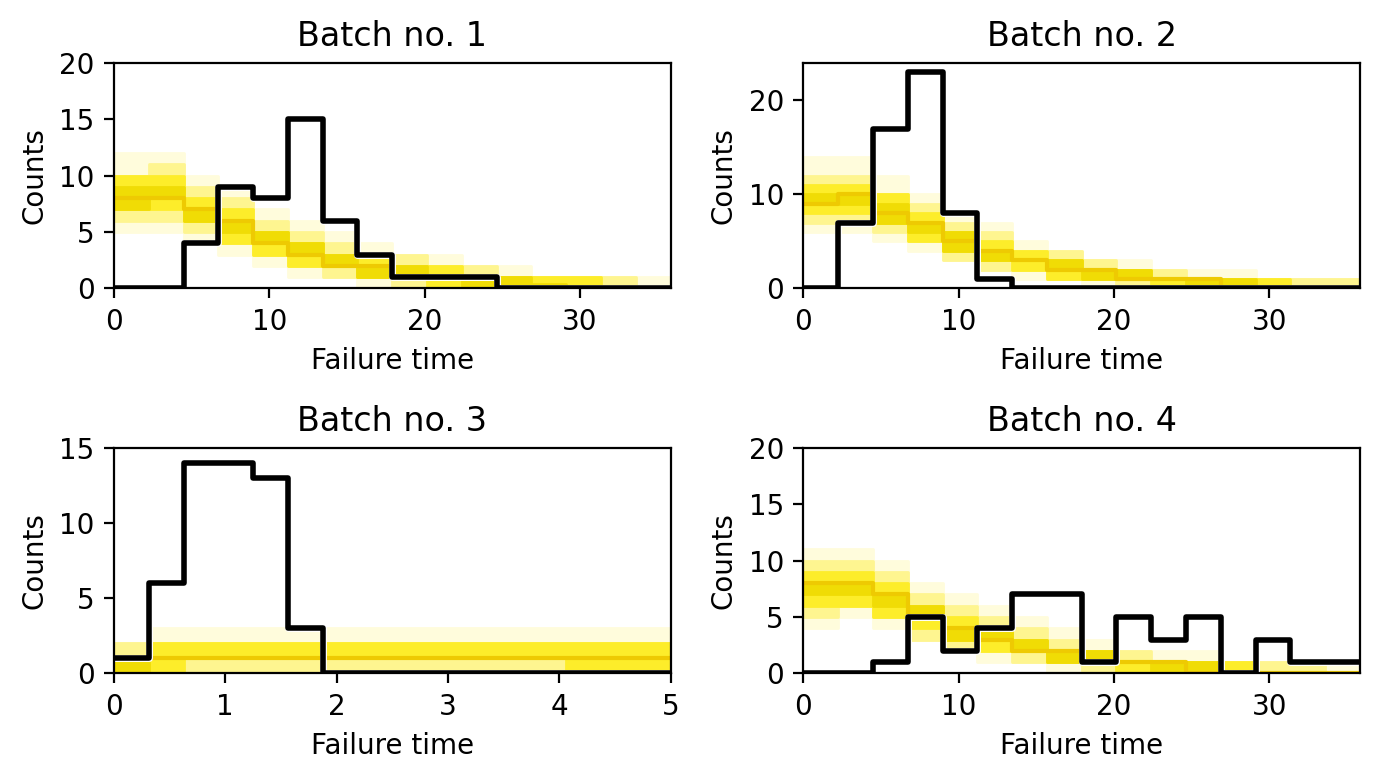

In [40]:
fig,axes = plt.subplots(2,2,figsize=(7,4))
axes=axes.flatten()
for batch_no in range(1,5):
    y_prediction_2 = infer_result.stan_variable('pred_failure_time')
    batch2 = np.array([failure_time[df.batch==batch_no] for failure_time in y_prediction_2])

    max_time = np.max(df.failure_time)
    if batch_no == 3:
        max_time = 5

    obs_counts,bins = np.histogram(df.failure_time[df.batch==batch_no],bins=np.linspace(0,max_time,17))

    _, pad_obs_counts = pad_hist_for_plot(bins,obs_counts)
    bins,counts = real_histogram_matrix(bins,batch2)
    xs, pad_counts_pred = pad_hist_for_plot(bins,counts)    

    ax2=axes[batch_no-1]

    ax2=ribbon_plot(xs,pad_counts_pred,ax2,supress_warning=True)
    ax2.plot(xs, pad_obs_counts, linewidth=2.5, color="white",zorder=1)
    ax2.plot(xs, pad_obs_counts, linewidth=2.0, color="black",zorder=2)
    ax2.set_xlim([min(bins), max(bins)])
    ax2.set_xlabel("Failure time")
    ax2.set_ylim([0, max(max(obs_counts), np.max(counts))+1])
    ax2.set_ylabel("Counts")
    ax2.set_title('Batch no. {}'.format(batch_no))
    fig.tight_layout()

fig.savefig('failure_simple_ppd_batches.png')


In [44]:
from numpy.random import default_rng
rng = default_rng(seed=31082021)
batch_PS = rng.choice([1,2,3,4], 1000, p=[0.6,0.2,0.1,0.1])

In [49]:
postratification = CmdStanModel(stan_file ='multilevel_inference2_poststrat.stan')


INFO:cmdstanpy:compiling stan program, exe file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/multilevel_inference2_poststrat
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/isz/src/python/iot/multilevel_inference2_poststrat


In [53]:
data_for_PS = {'N':200,
                'N_batch':4,
                'batch':df.batch.values,
                'resets':df.resets.values,
                'failure_time':df.failure_time.values,
                'N_PS':1000,
                'batch_PS':batch_PS}
poststrat_result = postratification.sample(data_for_PS,seed=29082021, adapt_delta=.99, max_treedepth=50)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [55]:
az.summary(poststrat_result,var_names=['quant20', 'median'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
quant20,5.971,0.245,5.519,6.443,0.004,0.003,3501.0,3559.0,1.0
median,10.064,0.362,9.395,10.750,0.006,0.004,3876.0,3530.0,1.0


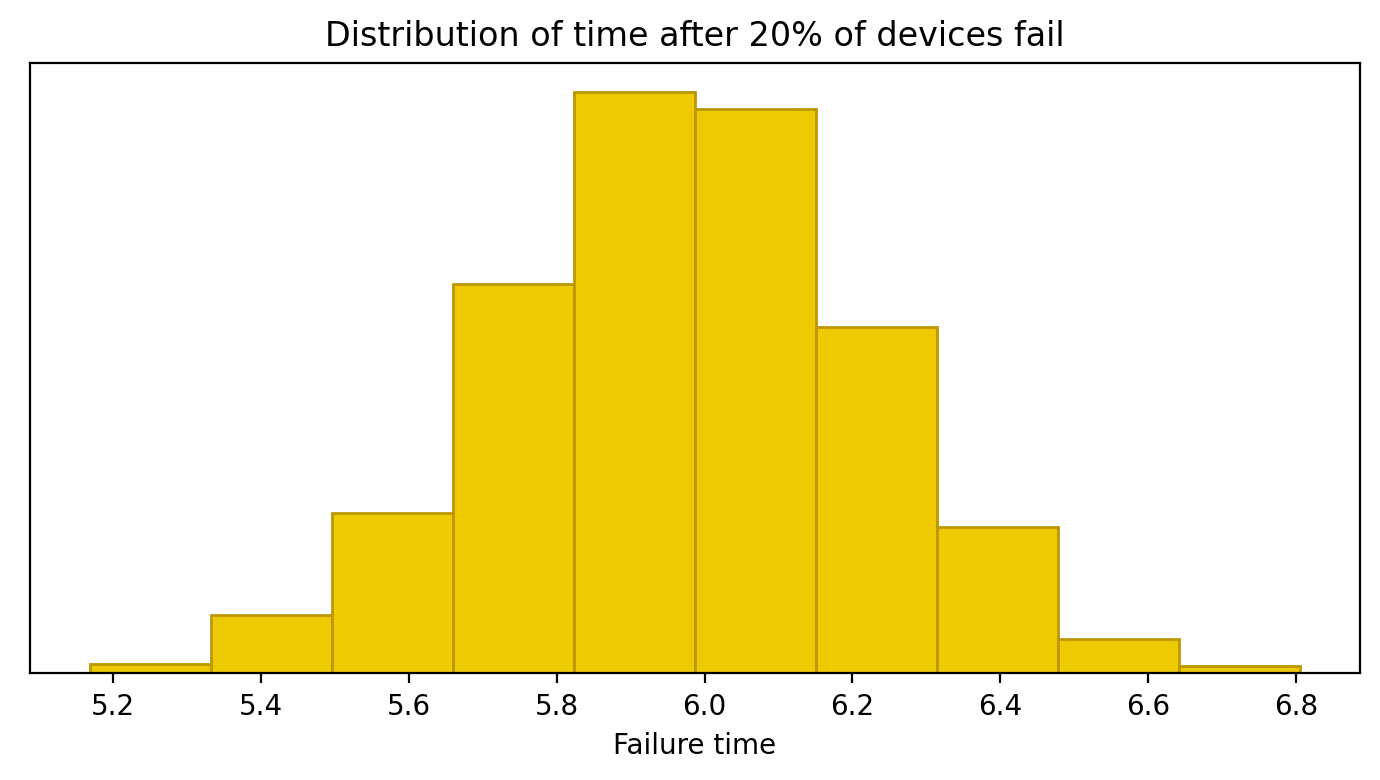

In [63]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.hist(poststrat_result.stan_variable('quant20'),color=DARK,ec=DARK_HIGHLIGHT,density=True)
ax.set_title('Distribution of time after 20% of devices fail')
ax.set_xlabel('Failure time')
ax.set_yticks([])
fig.tight_layout()
fig.savefig('quant20.png')

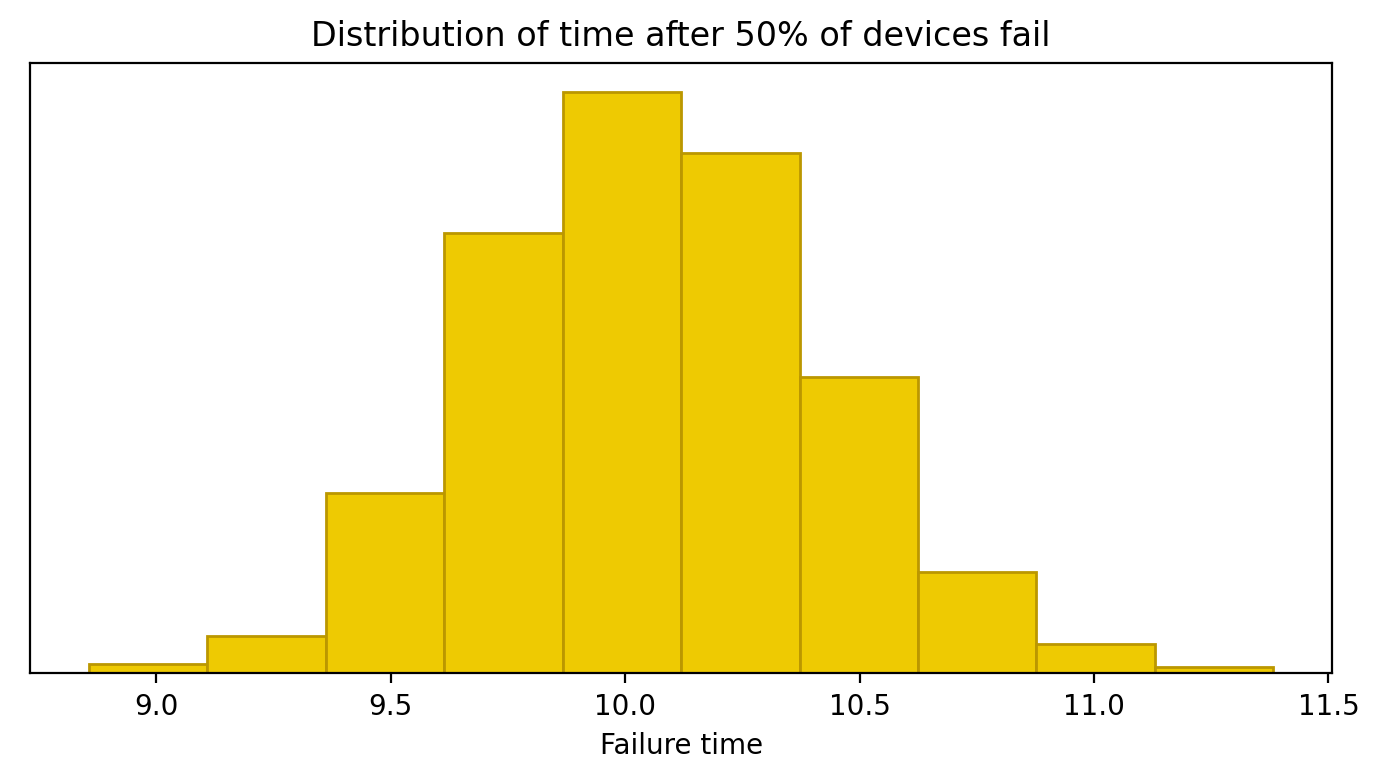

In [64]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.hist(poststrat_result.stan_variable('median'),color=DARK,ec=DARK_HIGHLIGHT,density=True)
ax.set_title('Distribution of time after 50% of devices fail')
ax.set_xlabel('Failure time')
ax.set_yticks([])
fig.tight_layout()
fig.savefig('median.png')